In [1]:
import skimage.measure as skm
import math
import cmath
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
from scipy.spatial.distance import pdist
import warnings
from skimage import io
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#Extracción de datos

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f78672f3590>],
      dtype=object)

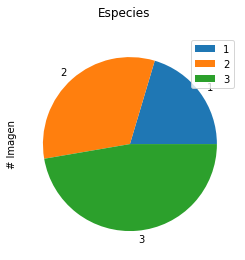

In [2]:
################################################# Importe de rutas en donde se encuentran alojadas las imágenes
ruta ="https://github.com/JuanDavid1703/Proyecto_INtroducci-n_ciencia-de-datos/raw/main/Imagenes/"
imgs=[]
for i in range(1,315):
  imgs.append(str(i)+".png")
warnings.filterwarnings('ignore')

# Datos de las tras diferentes especies tomadas en esudio 
Y=pd.read_excel("https://github.com/JuanDavid1703/Proyecto_INtroducci-n_ciencia-de-datos/raw/main/Proyecto/Especies.xlsx")

#Proporción de cada especie
Y.groupby(by="Especie").sum().plot(kind="pie",subplots=True,title="Especies")

##Funciones de extracción de características

In [3]:
def interparc(npoints, pxy):
    N = np.transpose(np.linspace(0,1,npoints))
    nt = N.size

    #number of points on the curve
    n = np.size(pxy, 0)
    #pxy = np.array((pX,pY)).T
    p1 = pxy[0,:]
    pend = pxy[-1,:]
    last_segment = np.linalg.norm(np.subtract(p1,pend))
    epsilon = 10*np.finfo(float).eps

    if last_segment > epsilon*np.linalg.norm(np.amax(abs(pxy),axis=0)):
        pxy=np.vstack((pxy,p1))
        nt = nt + 1
    else:
       pass

    datos = np.zeros((nt,2))

    chordlen = (np.sum(np.diff(pxy,axis=0)**2.0,axis=1))**(1/2)
    chordlen = chordlen/np.sum(chordlen)
    cumarc = np.append(0,np.cumsum(chordlen))

    tbins= np.digitize(N,cumarc)
    tbins[np.where(tbins<=0 | (N<=0))]=1
    tbins[np.where(tbins >= n | (N >= 1))] = n - 1      
    s = np.divide((N - cumarc[tbins]),chordlen[tbins-1])
    datos = pxy[tbins,:] + np.multiply((pxy[tbins,:] - pxy[tbins-1,:]),(np.vstack([s]*2)).T)

    return datos

###################################### Función para obtener los contornos de cada imagen 

def getContour(imName, npoints):
  im = io.imread(imName)
  imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(imgray,200, 255,0)
  contour=skm.find_contours(thresh,level=0.6, fully_connected="high")
  data=[]
  for points in contour:
    for i in points:
      data.append(i)
  contour=np.reshape(data, (len(data),2))
  contour=interparc(npoints,contour)
  meancon=np.mean(contour,axis=0)
  contour=(contour-meancon)/np.std(contour,axis=0)
  return contour,im
################################################## Características geométricas básicas elípticas

def props(path):
  im=io.imread(path)
  im=1-np.floor(im/255)[:,:,0]
  im=np.array(im,dtype=int)
  prop=skm.regionprops(im)[0]
  ar=prop.area
  per=prop.perimeter
  ma_x=prop.major_axis_length
  me_x=prop.minor_axis_length
  ex=prop.eccentricity
  cent=prop.centroid
  return ar,per,ex,ma_x,me_x,cent


Funciones de visualizavión de los datos

In [4]:
######################################################## funciones de viualización de los datos

def Grafica(im, contorno, path,tolerancia):
  fig, axs = plt.subplots(1,2)
  fig.set_size_inches(15,4)
  fig.tight_layout(pad=0.3)

  ################################### Imagen

  axs[0].set_title(path)
  axs[0].imshow(im)
  axs[0].axis("off")

  ############################################## Contorno
  x=contorno[:,0]
  y=contorno[:,1]
  axs[1].set_title(path)
  axs[1].set_ylim(bottom=1.5*min(y),top=1.5*max(y))
  axs[1].set_xlim(left=1.5*min(x),right=1.5*max(x))
  axs[1].plot(x,y,".")
  axs[1].axis("off")
  plt.show()   

Extracción de contornos 

In [5]:
#################################################Matriz de contornos
npoints=1024
Contorno=np.zeros(shape=(len(imgs),npoints,2))
Imagenes=[]
cont=0
for path in imgs:
  contor,im=getContour(ruta+path,npoints)
  Imagenes.append(im)
  Contorno[cont]=contor
  cont+=1

## Visualización algunas imágenes preprocesadas

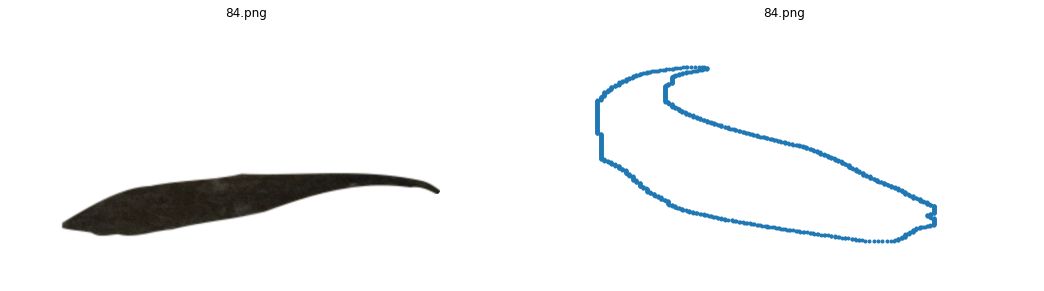

______________________________________________ E. Argentea ________________________________________________________


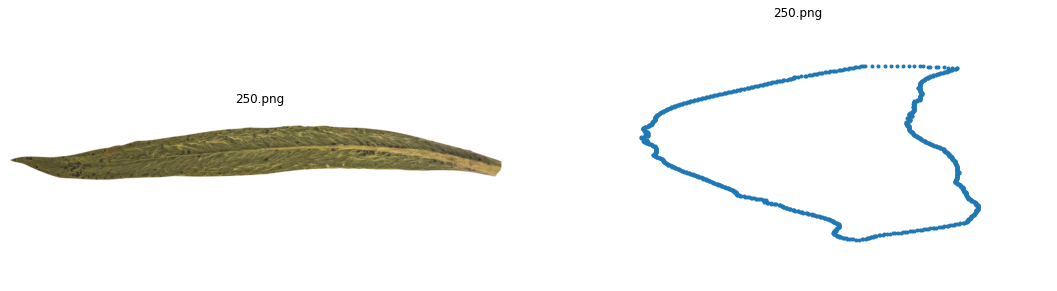

______________________________________________ E. Argentea ________________________________________________________


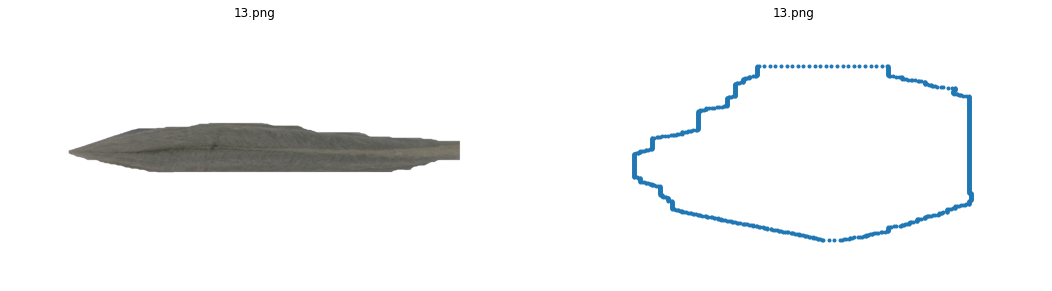

______________________________________________ E. Summapacis ________________________________________________________


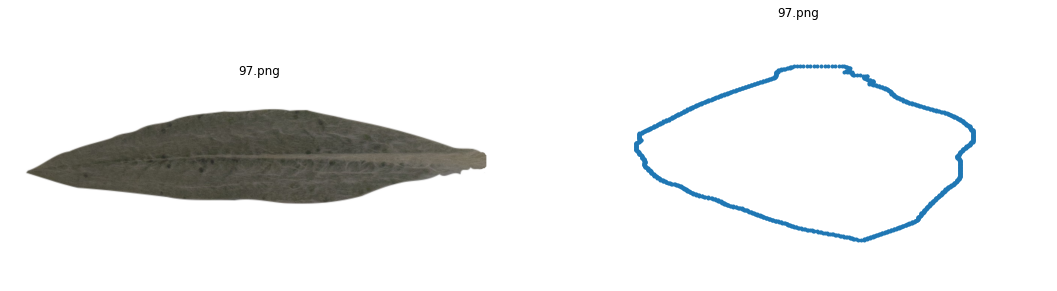

______________________________________________ E. Grandinflora ________________________________________________________


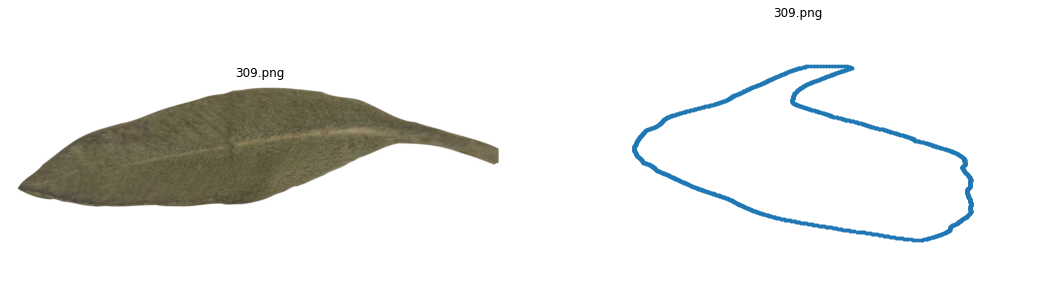

______________________________________________ E. Grandinflora ________________________________________________________


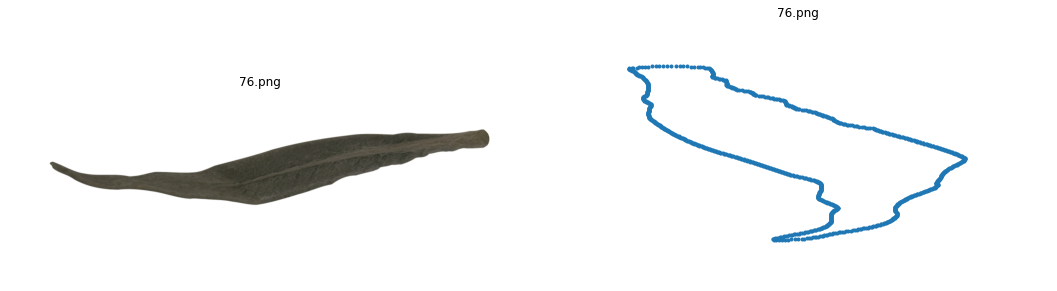

______________________________________________ E. Summapacis ________________________________________________________


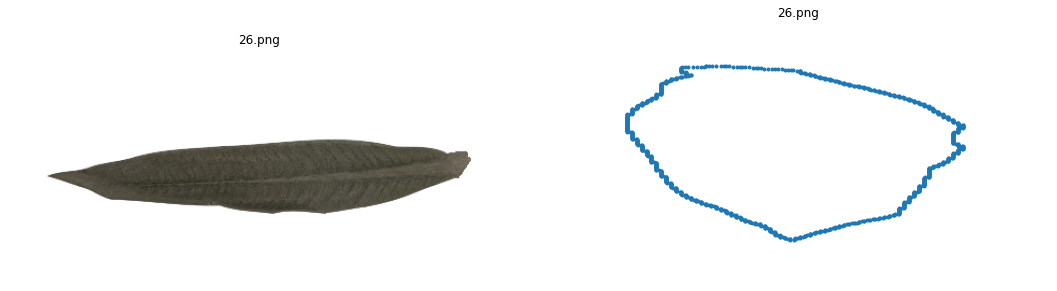

______________________________________________ E. Summapacis ________________________________________________________


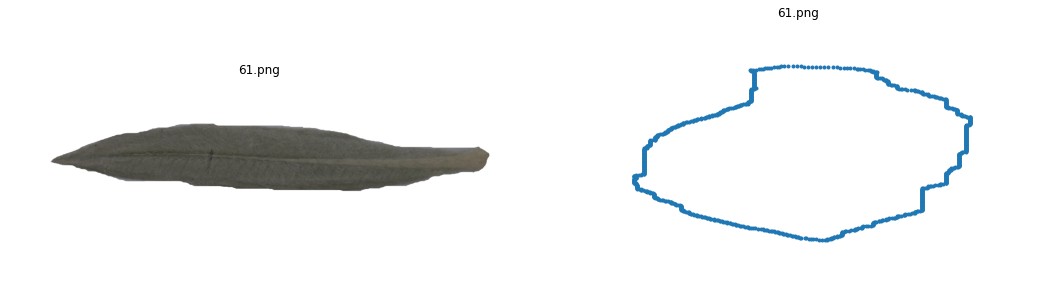

______________________________________________ E. Summapacis ________________________________________________________


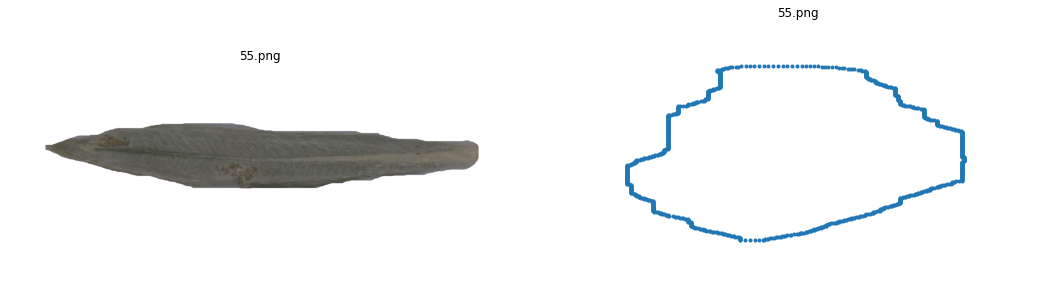

______________________________________________ E. Summapacis ________________________________________________________


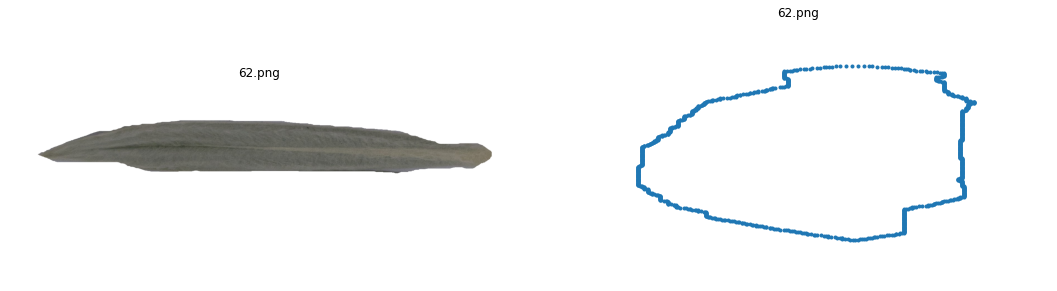

______________________________________________ E. Summapacis ________________________________________________________


In [6]:
for i in range(10):
  a=random.choice(range(len(imgs)))
  Grafica(Imagenes[a],Contorno[a],imgs[a],tolerancia=0.05)
  print("______________________________________________",Y["Nombres"][a],"________________________________________________________")

##Extracción Características:

###Características geométricas básicas

Dado que las hojas son figuras de contornos cerrados e inscribibles en una elipse es posible obtener las siguientes características de cada imagen 

In [7]:
################################# Características elípticas y geométricas
Area=[]
Perimetro=[]
Centro=[]
Eje_mayor=[]
Eje_menor=[]
Exentricidad=[]

for i in imgs:
  ar,per,ex,ma_x,me_x,cent=props(ruta+i)
  Area.append(ar)
  Perimetro.append(per)
  Exentricidad.append(ex)
  Eje_mayor.append(ma_x)
  Eje_menor.append(me_x)
  Centro.append(cent)


Ya que las características básicas dependen mucho dela resolución de la imagen, se pensó en generar un espacio usando las características básicas que describieran mejor los datos sin que la reslución de las imágenes afectaran los datos. Los datos obtenidos fueron:

$\begin{align*}
R_{1}=&\frac{Perimetro}{Area}\\
R_{2}=&\frac{Eje_{menor}}{Eje_{mayor}}\\
R_{3}=&\frac{Eje_{mayor}}{Perimetro}\\
R_{4}=&\frac{Eje_{menor}}{Perimetro}\\
R_{5}=&\frac{\sqrt{Eje_{mayor}^2-Eje_{menor}^2}}{Perimetro}\\
\end{align*}$



In [8]:
###############################Características básicas
Basic=pd.DataFrame(pd.read_excel("https://github.com/JuanDavid1703/Proyecto_INtroducci-n_ciencia-de-datos/raw/main/Proyecto/Caract_basicas.xlsx"))

############################### Creación del espacio de datos que caracterizarán lás imágenes mediante las características básicas usando las formulas anteriores 
Es1=pd.DataFrame()
Es1["P/A"]=Basic["Pe"]/Basic["Ar"]
Es1["Ejmay/P"]=Basic["Ejmay"]/Basic["Pe"]
Es1["Ejmenor/P"]=Basic["Ejmen"]/Basic["Pe"]
Es1["Emen/Ejmay"]=Basic["Ejmen"]/Basic["Ejmay"]
Es1["C"]=(Basic["Ejmay"]**2-Basic["Ejmen"]**2)**(1/2)/Basic["Pe"]
Es1["Label"]=Y["Especie"]

In [9]:
Es1.head(10)

,P/A,Ejmay/P,Ejmenor/P,Emen/Ejmay,C,Label
0,0.038408,0.425035,0.084882,0.199706,0.416473,1
1,0.046718,0.410982,0.061143,0.148772,0.406409,2
2,0.042703,0.410738,0.081196,0.197683,0.402632,1
3,0.052595,0.428959,0.075139,0.175167,0.422327,3
4,0.061743,0.362798,0.051411,0.141707,0.359136,2
5,0.007216,0.379861,0.084708,0.222996,0.370295,1
6,0.017858,0.462474,0.035142,0.075988,0.461137,2
7,0.014915,0.439603,0.065026,0.147920,0.434767,3
8,0.075226,0.528565,0.040561,0.076737,0.527006,2
9,0.037604,0.425026,0.089486,0.210543,0.415499,2


#Análisis de los datos de primicia

Creación de los espacios

In [10]:
##########El espaciosya había sido creado inicialmente y fue guardado en un servidor

###############Espacio de características creado a partir de las características básicas
Espacio1=pd.DataFrame(pd.read_excel("https://github.com/JuanDavid1703/Proyecto_INtroducci-n_ciencia-de-datos/raw/main/Proyecto/Espacio_basicos.xlsx"))


##Análisis del Espacio de características básicas

Descripción general con las medidas de tendencia central

In [11]:
Espacio1.describe()

,P/A,Ejmay/P,Ejmenor/P,Emen/Ejmay,C,Label
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,0.019121,0.430903,0.063175,0.149502,0.425659,2.219745
std,0.013794,0.029895,0.018521,0.051867,0.032455,0.782879
min,0.005763,0.360807,0.025922,0.051689,0.344126,1.000000
25%,0.011911,0.410799,0.051207,0.114871,0.406381,2.000000
50%,0.015281,0.429906,0.062360,0.145151,0.424389,2.000000
75%,0.019168,0.449483,0.076350,0.180522,0.446739,3.000000
max,0.092152,0.533053,0.122211,0.327333,0.532132,3.000000


<Figure size 504x360 with 0 Axes>

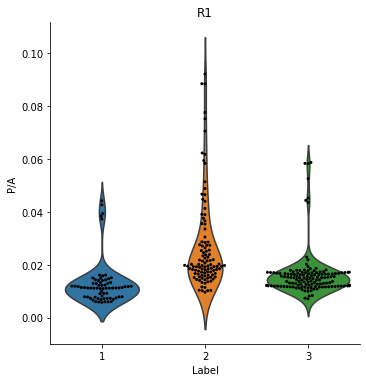

<Figure size 504x360 with 0 Axes>

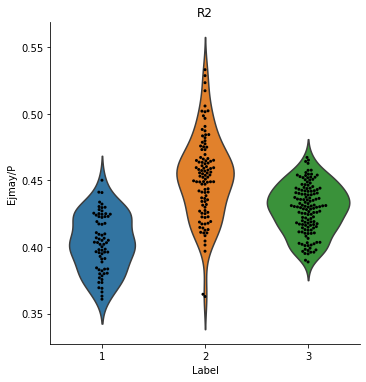

<Figure size 504x360 with 0 Axes>

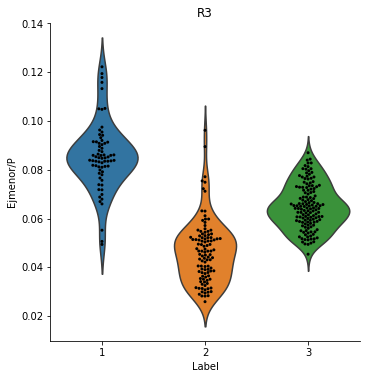

<Figure size 504x360 with 0 Axes>

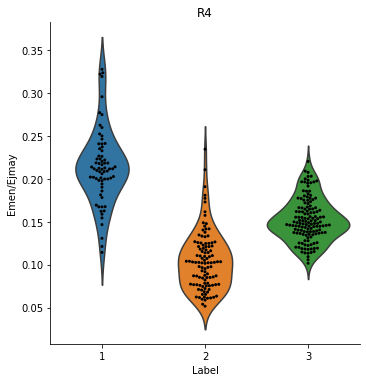

<Figure size 504x360 with 0 Axes>

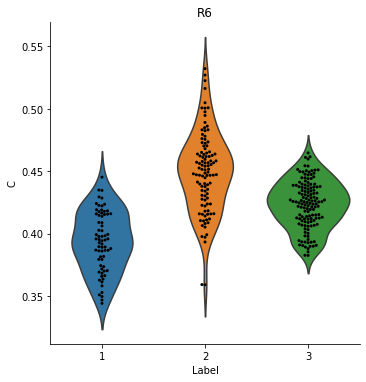

In [12]:
plt.figure(figsize=(7,5))
g=sns.catplot(x="Label",y="P/A",data=Espacio1, kind="violin",inner=None)
sns.swarmplot(x="Label",y="P/A",data=Espacio1 , size=3, ax=g.ax, color="k")
plt.title("R1")
plt.show()
plt.figure(figsize=(7,5))
g=sns.catplot(x="Label",y="Ejmay/P",data=Espacio1, kind="violin",inner=None)
sns.swarmplot(x="Label",y="Ejmay/P",data=Espacio1 , size=3, ax=g.ax, color="k")
plt.title("R2")
plt.show()
plt.figure(figsize=(7,5))
g=sns.catplot(x="Label",y="Ejmenor/P",data=Espacio1, kind="violin",inner=None)
sns.swarmplot(x="Label",y="Ejmenor/P",data=Espacio1 , size=3, ax=g.ax, color="k")
plt.title("R3")
plt.show()
plt.figure(figsize=(7,5))
g=sns.catplot(x="Label",y="Emen/Ejmay",data=Espacio1, kind="violin",inner=None)
sns.swarmplot(x="Label",y="Emen/Ejmay",data=Espacio1 , size=3, ax=g.ax, color="k")
plt.title("R4")
plt.show()
plt.figure(figsize=(7,5))
g=sns.catplot(x="Label",y="C",data=Espacio1, kind="violin",inner=None)
sns.swarmplot(x="Label",y="C",data=Espacio1 , size=3, ax=g.ax, color="k")
plt.title("R6")
plt.show()


Matriz de Correlación del espacio 1

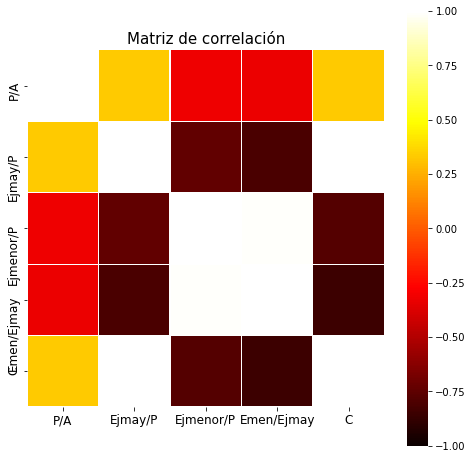

In [13]:
Corr=Espacio1[Espacio1.columns[:5]].corr(method="pearson")
plt.figure(figsize=(8,8))
sns.heatmap(Corr,vmin=-1,vmax=1, xticklabels=Corr.columns,yticklabels=Corr.columns, cmap="hot",square=True,linewidths=0.1,)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Matriz de correlación", fontdict={'fontsize':15})
plt.show()


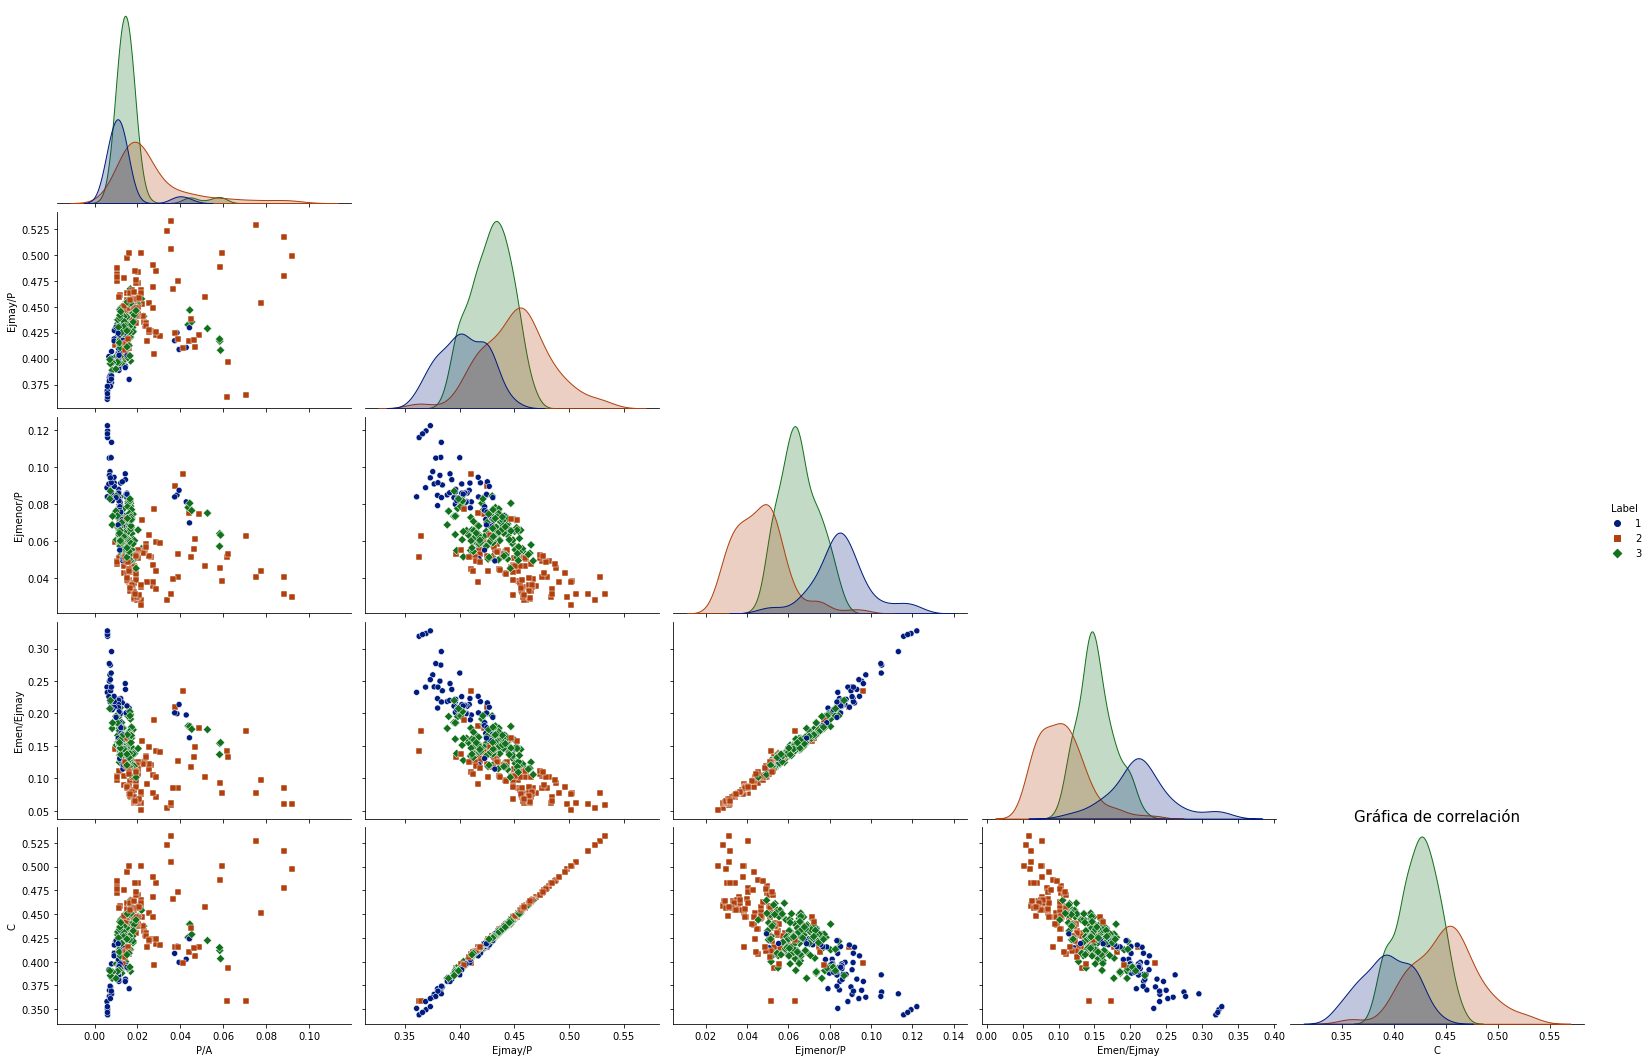

In [14]:
sns.pairplot(data=Espacio1,hue="Label",palette="dark",corner=True,markers=["o", "s", "D"],size=3,aspect=1.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Gráfica de correlación", fontdict={'fontsize':15})
plt.show()

Se realiza una reducción del espacio usando PCA y TSNE para observar si hay una separación observable, se puede ver que PCA muestra una aceptable partición del espacio.

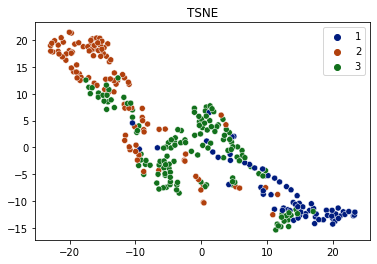

In [15]:
X=np.array(Espacio1[Espacio1.columns[:5]])
y=np.array(Espacio1["Label"])

########TSNE descomposition
tsne=TSNE(n_components=2)
data2=tsne.fit_transform(X,y)
sns.scatterplot(x=data2[:,0],y=data2[:,1],hue=y,palette='dark')
plt.title("TSNE")
plt.show()


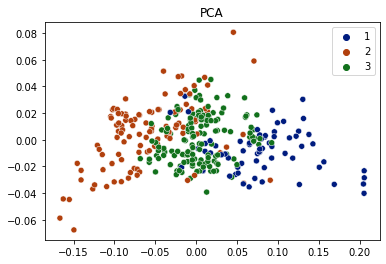

In [16]:

########PCA descomposition
pca=PCA(n_components=2)
data1=pca.fit_transform(X,y)
sns.scatterplot(x=data1[:,0],y=data1[:,1],hue=y,palette='dark')
plt.title("PCA")
plt.show()

#Modelos a usar

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score,precision_score,f1_score


In [18]:
############Función para aplicar el modleo a los datos
names = ["Random Forest", "ExtraTreesClassifier" , "NearestNeighbor"]

def run_model(X_train, X_test, y_train, y_test):
  #cv=LeaveOneOut()
  #Hiperespacio para Randomforest y Extratreeclassifier
  space_opc1={"n_estimators":[10,20,50,100],"min_samples_leaf":[5,10,50]}

  #Hiperespacio para Knearestneighbor
  space_opc2={"n_neighbors": [3,5,10,20],"leaf_size":[15,30,45]}

  search_forest = GridSearchCV(RandomForestClassifier(max_depth=5, max_features=2,class_weight="balanced",n_jobs=-1,random_state=42,oob_score=True),
                               param_grid=space_opc1,scoring="accuracy",refit=True)
  forest = search_forest.fit(X_train, y_train)
  clf_forest=forest.best_estimator_
  parm_forest=forest.best_params_

  search_tree = GridSearchCV(ExtraTreesClassifier(max_depth=5, max_features=2,class_weight="balanced",n_jobs=-1,random_state=42,oob_score=True,bootstrap=True),
                               param_grid=space_opc1,scoring="accuracy",refit=True)
  tree = search_tree.fit(X_train, y_train)
  clf_tree=tree.best_estimator_
  parm_tree=tree.best_params_

  search_knei =GridSearchCV(KNeighborsClassifier(weights="distance",n_jobs=-1),
                            param_grid=space_opc2,scoring="accuracy", refit=True,verbose=0,return_train_score=True)
  knei = search_knei.fit(X_train, y_train)
  clf_knei = knei.best_estimator_
  parm_knei=knei.best_params_

  return [clf_forest,clf_tree,clf_knei],[parm_forest,parm_tree,parm_knei]


###############################################################################################


#######Función para mostrar resultados de los modelos
def mostrar_resultados(y_test, pred_y):
    eje=["E. Grandinflora","E. Argentea", "E. summapacis"]
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, xticklabels=eje, yticklabels=eje, annot=True, fmt="d");
    plt.title("Matriz de Confusión")
    plt.ylabel('Clase verdadera')
    plt.xlabel('Clase predecida')
    plt.rc('axes', labelsize=10)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(rotation=45,fontsize=10)
    plt.show()
    acc=accuracy_score(y_test, pred_y)
    recall=recall_score(y_test, pred_y,average=None)
    preci=precision_score(y_test, pred_y,average=None)
    f1score=f1_score(y_test, pred_y,average=None)
    print(classification_report(y_test, pred_y))
    return acc,recall,preci,f1score

###### Función que muestra los resultados de la matriz de confusión
def mostrar_resultado(y_test, pred_y):
    acc=accuracy_score(y_test, pred_y)
    recall=recall_score(y_test, pred_y,average=None)
    preci=precision_score(y_test, pred_y,average=None)
    f1score=f1_score(y_test, pred_y,average=None)
    return acc,recall,preci,f1score


def resultados(name, score, Data_name,param, taman=(10,5), lsize=12):
  score=np.array(score)
  Data_name=np.array(Data_name)
  param=np.array(param)

  ####### Gráfica de los scores obtenidos en cada modelo para los diferentes subgrupos

  plt.figure(figsize=taman)
  plt.scatter(Data_name,score[:,0],color="blue", label=name[0],marker="o",s=100)
  plt.scatter(Data_name,score[:,1],color="orange", label=name[1],marker="v",s=100)
  plt.scatter(Data_name,score[:,2],color="red", label=name[2],marker="s",s=100)
  plt.rc('axes', labelsize=lsize)
  plt.xticks(rotation=60, fontsize=12)
  plt.yticks(fontsize=12)
  plt.xlabel("Subgrupos analizados")
  plt.ylabel("Precisión")
  plt.legend()
  plt.show()

  ######## Presentación de los mejores scores para cada modelo
  print("Mejor accuracy para RandomForest: ", np.max(score[:,0]),"Grupo obtenido",Data_name[np.where(score[:,0]==np.max(score[:,0]))])
  print("Parámetros: ",param[:,0][np.where(score[:,0]==np.max(score[:,0]))][0])
  print("________________________________________________________________________________________________________________")
  print("Mejor accuracy para Extratrees: ", np.max(score[:,1]),"Grupo obtenido",Data_name[np.where(score[:,1]==np.max(score[:,1]))])
  print("Parámetros:",param[:,1][np.where(score[:,1]==np.max(score[:,1]))][0])
  print("________________________________________________________________________________________________________________")
  print("Mejor accuracy para NearestNeighbor: ", np.max(score[:,2]),"Grupo obtenido",Data_name[np.where(score[:,2]==np.max(score[:,2]))])
  print("Parámetros:",param[:,2][np.where(score[:,2]==np.max(score[:,2]))][0])
  print("________________________________________________________________________________________________________________")

##Entrenamiento de modelos del espacio creado.

**Análisis del espacio completo**

In [19]:
#### Espacio completo
y = Espacio1["Label"]
X = Espacio1.drop("Label", axis=1)

#dividimos en sets de entrenamiento y testeo
seed=42
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70,shuffle=True,random_state=seed)

Random Forest


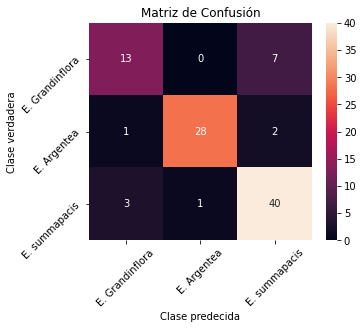

              precision    recall  f1-score   support

           1       0.76      0.65      0.70        20
           2       0.97      0.90      0.93        31
           3       0.82      0.91      0.86        44

    accuracy                           0.85        95
   macro avg       0.85      0.82      0.83        95
weighted avg       0.85      0.85      0.85        95

ExtraTreesClassifier


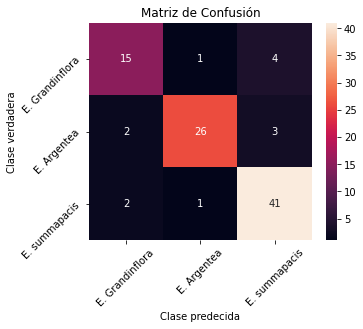

              precision    recall  f1-score   support

           1       0.79      0.75      0.77        20
           2       0.93      0.84      0.88        31
           3       0.85      0.93      0.89        44

    accuracy                           0.86        95
   macro avg       0.86      0.84      0.85        95
weighted avg       0.86      0.86      0.86        95

NearestNeighbor


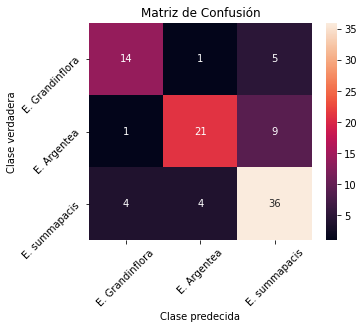

              precision    recall  f1-score   support

           1       0.74      0.70      0.72        20
           2       0.81      0.68      0.74        31
           3       0.72      0.82      0.77        44

    accuracy                           0.75        95
   macro avg       0.75      0.73      0.74        95
weighted avg       0.75      0.75      0.75        95



In [20]:
#################### Matrices de confusión para el entrenamiento de los modelos en el espacio completo
#Acc=[]
models, params=run_model(X_train,X_test,y_train,y_test)
cont=0
for model in models:
  print(names[cont])
  pred_y = model.predict(X_test)
  acc,recall,preci,f1score = mostrar_resultados(y_test, pred_y)
  cont+=1
  #acc,recall,preci,f1score = mostrar_resultado(y_test, pred_y)
  #Acc.append(acc)
#a=np.reshape(Acc,newshape=(15,3))
#sns.histplot(a)

**Espacio por parejas**

In [21]:
#########Espacio por parejas de características

Nombres=Espacio1.columns.values[:5]
Train_Datasets=[]
Test_Datasets=[]
Ndatasets=[]

######### Creación de los espacios por subgrupos de parejas

for i in range(len(Nombres)):
  for j in range(len(Nombres)):
    if i<j:
      Train_Datasets.append(X_train[[Nombres[i],Nombres[j]]])
      Test_Datasets.append(X_test[[Nombres[i],Nombres[j]]])
      Ndatasets.append([Nombres[i],Nombres[j]])
Ndatasets=np.array(Ndatasets)
scores=[]
param_parejas=[]
Data_names=[]

###### Aplicación del modelo a cada grupo
for x_train, x_val in zip(Train_Datasets,Test_Datasets):
  models,params=run_model(x_train,x_val,y_train,y_test)
  param_parejas.append(params)
  results=[]
  cont=0
  for model in models:
    ## Predicción sobre los datos de tsteo para cada agrupamiento
    pred_y = model.predict(x_val)
    ## Obtención del desempeño
    acc,_,_,_= mostrar_resultado(y_test, pred_y)
    results.append(acc)
    cont+=1
  scores.append(results)
  ##Obtención de las características mejor valoradas
  Data_names.append(str(x_train.columns[0]+" Vs "+x_train.columns[1]))  

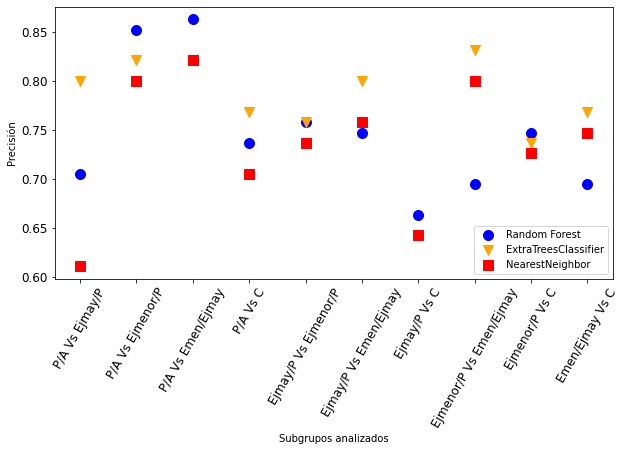

Mejor accuracy para RandomForest:  0.8631578947368421 Grupo obtenido ['P/A Vs Emen/Ejmay']
Parámetros:  {'min_samples_leaf': 10, 'n_estimators': 50}
________________________________________________________________________________________________________________
Mejor accuracy para Extratrees:  0.8315789473684211 Grupo obtenido ['Ejmenor/P Vs Emen/Ejmay']
Parámetros: {'min_samples_leaf': 10, 'n_estimators': 10}
________________________________________________________________________________________________________________
Mejor accuracy para NearestNeighbor:  0.8210526315789474 Grupo obtenido ['P/A Vs Emen/Ejmay']
Parámetros: {'leaf_size': 15, 'n_neighbors': 20}
________________________________________________________________________________________________________________


In [22]:
### Visualización de los resultados por parejas
resultados(names ,scores, Data_names,param_parejas, taman=(10,5),lsize=18)


**Espacio por triplas**

In [23]:

Nombres=Espacio1.columns.values[:5]
Train_Datasets=[]
Test_Datasets=[]
Ndatasets=[]

######### Creación de los espacios por subgrupos de triplas

for i in range(len(Nombres)):
  for j in range(len(Nombres)):
    for k in range(len(Nombres)):
      if i<j and j<k:
        Train_Datasets.append(X_train[[Nombres[i],Nombres[j],Nombres[k]]])
        Test_Datasets.append(X_test[[Nombres[i],Nombres[j],Nombres[k]]])
        Ndatasets.append([Nombres[i],Nombres[j],Nombres[k]])
Ndatasets=np.array(Ndatasets)
scores=[]
param_triplas=[]
Data_names=[]

###### Aplicación del modelo a cada grupo
for x_train, x_val in zip(Train_Datasets,Test_Datasets):
  models,paramas=run_model(x_train,x_val,y_train,y_test)
  param_triplas.append(params)
  results=[]
  cont=0
  for model in models:
    ## Predicción sobre los datos de tsteo para cada agrupamiento
    pred_y = model.predict(x_val)
    ## Obtención del desempeño
    acc,_,_,_= mostrar_resultado(y_test, pred_y)
    results.append(acc)
    cont+=1
  scores.append(results)
  ## Obtención de las características mejor valoradas
  Data_names.append(str(x_train.columns[0]+"|"+x_train.columns[1]+"|"+x_train.columns[2]))  

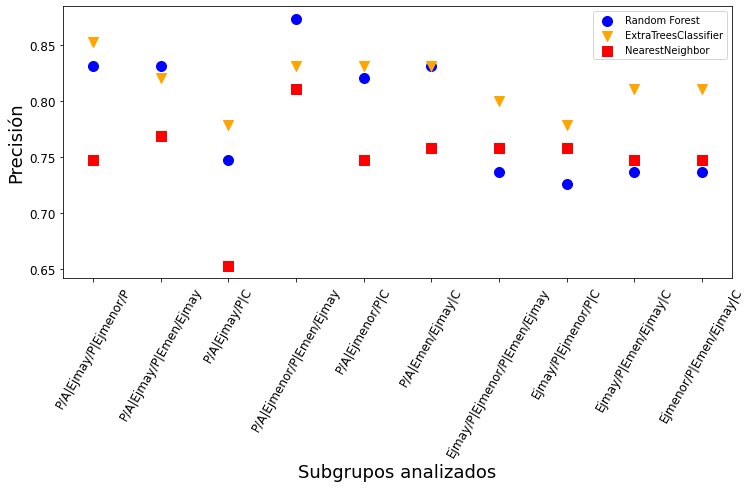

Mejor accuracy para RandomForest:  0.8736842105263158 Grupo obtenido ['P/A|Ejmenor/P|Emen/Ejmay']
Parámetros:  {'min_samples_leaf': 5, 'n_estimators': 10}
________________________________________________________________________________________________________________
Mejor accuracy para Extratrees:  0.8526315789473684 Grupo obtenido ['P/A|Ejmay/P|Ejmenor/P']
Parámetros: {'min_samples_leaf': 5, 'n_estimators': 10}
________________________________________________________________________________________________________________
Mejor accuracy para NearestNeighbor:  0.8105263157894737 Grupo obtenido ['P/A|Ejmenor/P|Emen/Ejmay']
Parámetros: {'leaf_size': 15, 'n_neighbors': 5}
________________________________________________________________________________________________________________


In [24]:
### Visualización de los resultados por triplas
resultados(names ,scores, Data_names,param_triplas, taman=(12,5),lsize=18)

**Espacio por cuartetos**

In [25]:
Nombres=Espacio1.columns.values[:5]
Train_Datasets=[]
Test_Datasets=[]
Ndatasets=[]
######### Creación de los espacios por subgrupos de cuartetos
for i in range(len(Nombres)):
  for j in range(len(Nombres)):
    for k in range(len(Nombres)):
      for t in range(len(Nombres)):
        if i<j and j<k and k<t:
          Train_Datasets.append(X_train[[Nombres[i],Nombres[j],Nombres[k],Nombres[t]]])
          Test_Datasets.append(X_test[[Nombres[i],Nombres[j],Nombres[k],Nombres[t]]])
          Ndatasets.append([Nombres[i],Nombres[j],Nombres[k],Nombres[t]])
Ndatasets=np.array(Ndatasets)
scores=[]
param_cuadruplas=[]
Data_names=[]

###### Aplicación del modelo a cada grupo
for x_train, x_val in zip(Train_Datasets,Test_Datasets):
  models,paramas=run_model(x_train,x_val,y_train,y_test)
  param_cuadruplas.append(params)
  results=[]
  cont=0
  for model in models:
    ## Predicción sobre los datos de tsteo para cada agrupamiento
    pred_y = model.predict(x_val)
    ## Obtención del desempeño
    acc,_,_,_= mostrar_resultado(y_test, pred_y)
    results.append(acc)
    cont+=1
  scores.append(results)
  ## Obtención de las características mejor valoradas
  Data_names.append(str(x_train.columns[0]+"|"+x_train.columns[1]+"|"+x_train.columns[2]+"|"+x_train.columns[3])) 

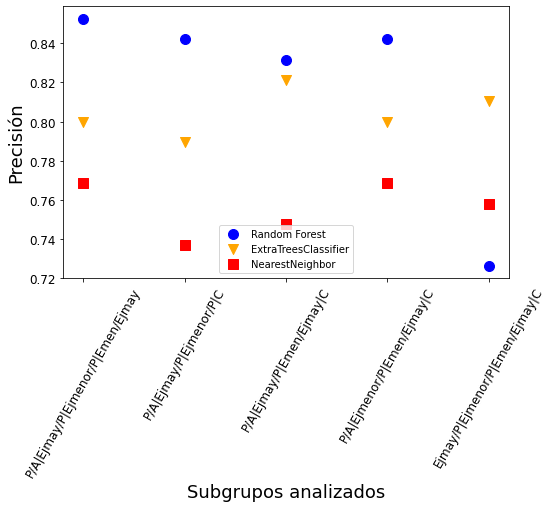

Mejor accuracy para RandomForest:  0.8526315789473684 Grupo obtenido ['P/A|Ejmay/P|Ejmenor/P|Emen/Ejmay']
Parámetros:  {'min_samples_leaf': 5, 'n_estimators': 10}
________________________________________________________________________________________________________________
Mejor accuracy para Extratrees:  0.8210526315789474 Grupo obtenido ['P/A|Ejmay/P|Emen/Ejmay|C']
Parámetros: {'min_samples_leaf': 5, 'n_estimators': 10}
________________________________________________________________________________________________________________
Mejor accuracy para NearestNeighbor:  0.7684210526315789 Grupo obtenido ['P/A|Ejmay/P|Ejmenor/P|Emen/Ejmay' 'P/A|Ejmenor/P|Emen/Ejmay|C']
Parámetros: {'leaf_size': 15, 'n_neighbors': 5}
________________________________________________________________________________________________________________


In [26]:
### Visualización de los resultados por cuartetos
resultados(names ,scores, Data_names,param_cuadruplas, taman=(8,5),lsize=20)

**Modelo escogido:** El clasificador con un mejor rendimiento fue Randomforest, el grupo escogido ha sido el que está conformado por las tripletas y el subgrupo es 'P/A, Ejmenor/P, Emen/Ejmay' con una presición de 0.87368 con los parámetros:

* min_samples_leaf= 5 
* n_estimators= 10
* max_depth=5 
* max_features=2 
* class_weight="balanced"
* n_jobs=-1 
* random_state=42 
* oob_score=True

In [27]:
################### Modelo escogido con sus respectivos parámetros
Final_model=RandomForestClassifier(min_samples_leaf= 5, n_estimators= 10, max_depth=5, max_features=2,
                                   class_weight="balanced", n_jobs=-1, random_state=42, oob_score=True)
# Grupo escogido ["P/A","Ejmenor/P","Emen/Ejmay"]
X_final=X[["P/A","Ejmenor/P","Emen/Ejmay"]]
Final_model=Final_model.fit(X_final,y)

#Algunos errores del modelo

Especies mal clasificadas:

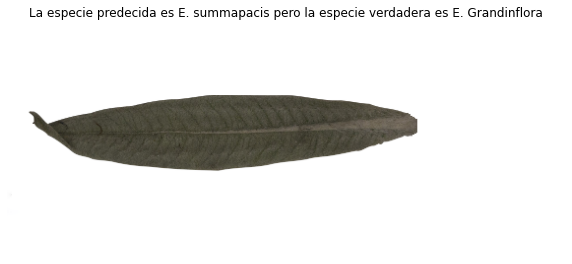

In [28]:
especie=["E. Grandinflora","E. Argentea", "E. summapacis"]
pre_final=Final_model.predict(X_final)
id=pre_final-y
cont=0
while True:
  if id[cont]!=0:
    break
  cont+=1
cont
plt.figure(figsize=(10,10))
plt.imshow(Imagenes[cont])
plt.axis("off")
plt.title(f"La especie predecida es {especie[int(pre_final[cont]-1)]} pero la especie verdadera es {especie[int(y[cont]-1)]}")
plt.show()